# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifies the breed of a dog in an image.

When I'm sitting at a cafe and I take a picture of a dog, I want to know what breed it is.

## 2. Data
The data were using is from the Kaggle Dog Breed Identification competition. https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


In [1]:
# from colabcode import ColabCode

# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
# Improt necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

# Check if GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2.17.0
0.16.1
Num GPUs Available:  0


## Getting our data ready (turning into Tensors)

With all machin learning models, our data has to be in numerical format. So that's what we'll be doing first.
(numerical representation).

Let's start by accessing our data and checking out the labels.

In [4]:
# Check the labels of our dataset
import pandas as pd
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

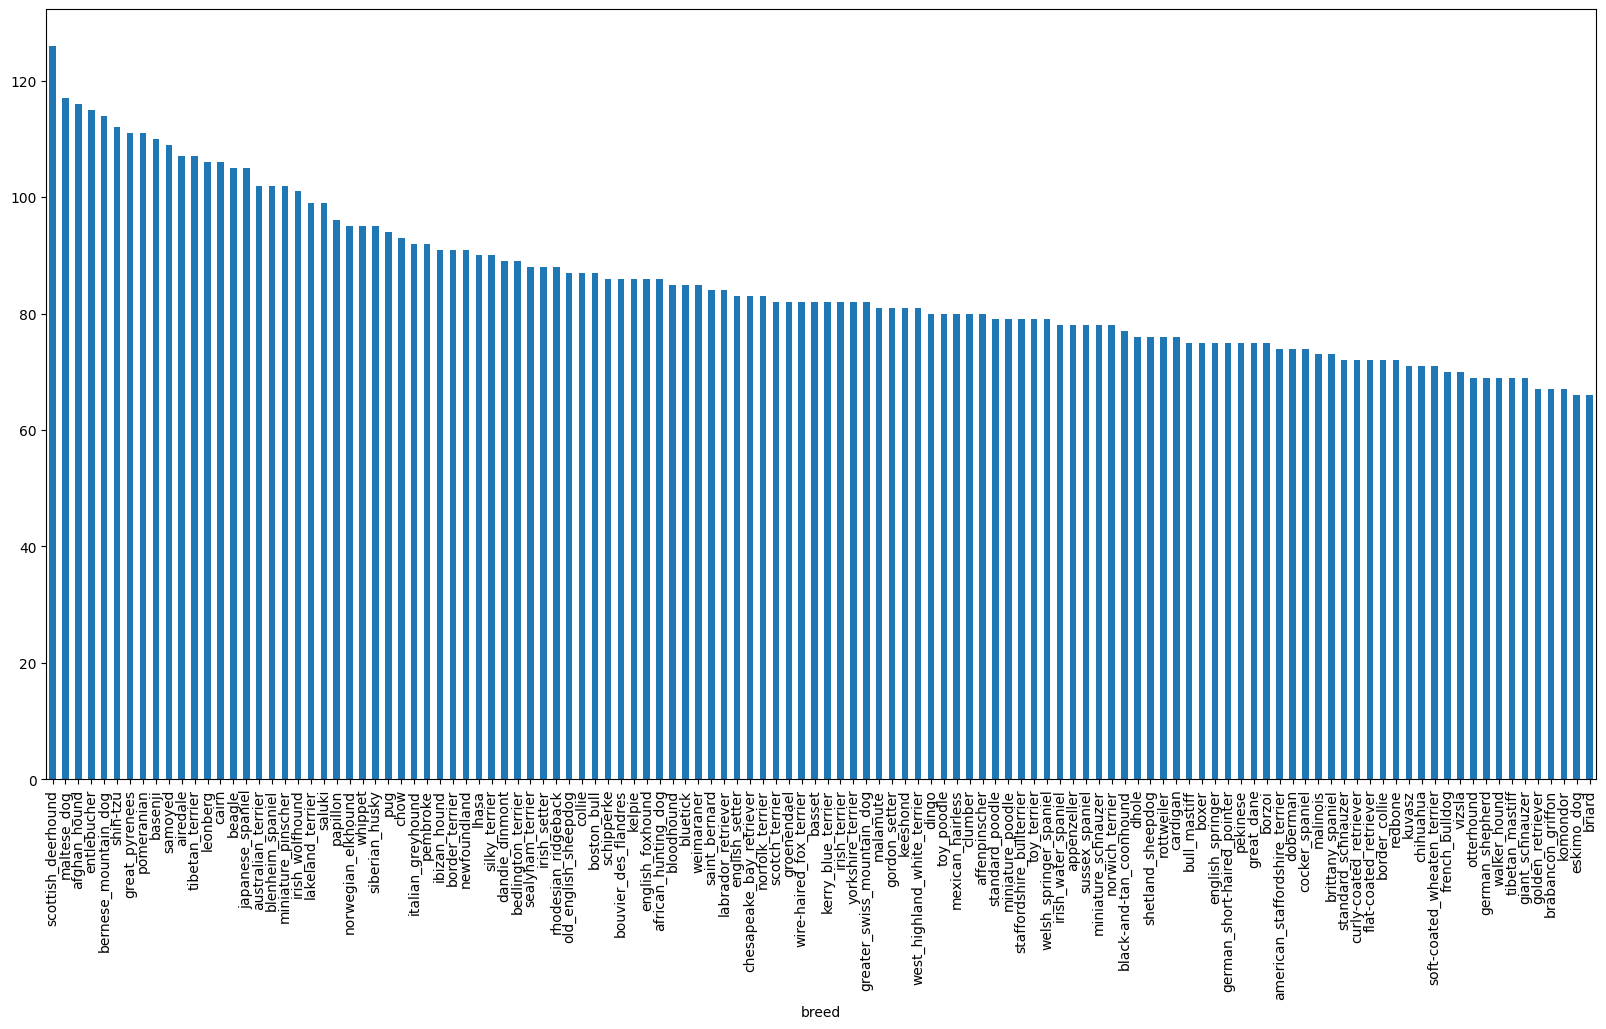

In [6]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

In [7]:
labels_csv['breed'].value_counts().median()

82.0

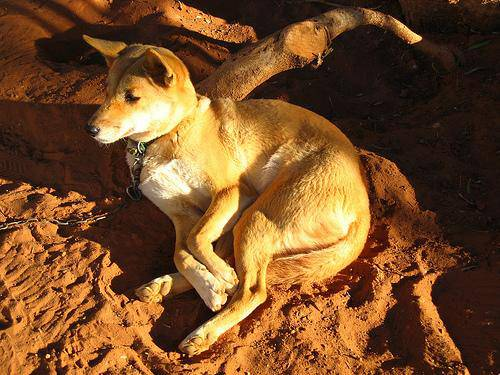

In [8]:
# Let's view an image
from IPython.display import Image
Image('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

# Getting images and their labels

Let's get a list of all of our image file pathnames.

In [9]:
# Create pathnames from image IDs
filenames = ["data/train/" + fname for fname in labels_csv['id'] + ".jpg"]

# Check the first 10 filenames
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
import os
os.listdir("data/train")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('data/train/')) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")
  

Filenames match actual amount of files!!! Proceed.


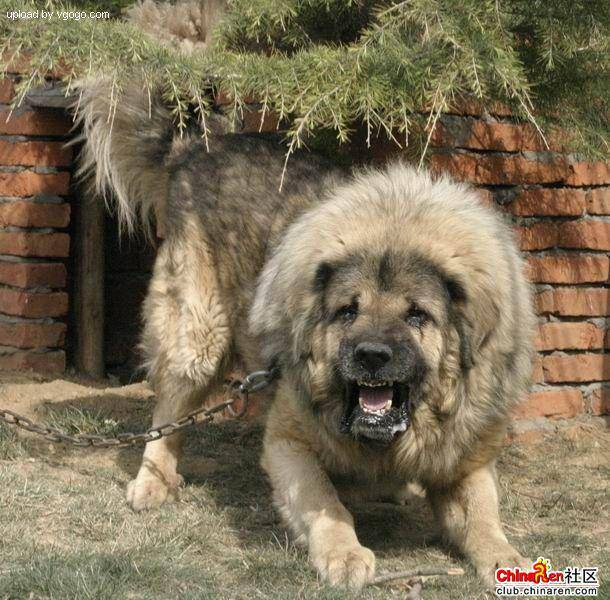

In [12]:
# One more check
Image(filenames[9000])

In [13]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames


In [17]:
# Find the unique label values
unique_breeds = np.unique(labels) 
len(unique_breeds)

120

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [labels == unique_breeds for labels in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset doesn't come with a validation set, we're going to create one.

In [22]:
# Setup X & y variables
x = filenames
y = boolean_labels



We're going to start off experimenting with ~1000 images and increase as needed.

In [23]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [24]:
# Let's split our data into training and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [25]:
# Let's have a geez at the training data
x_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocess images (convert to tensors)
To preprocess our images (converting them into tensors), we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our image (a jpg) into Tensors
4. Resize the image to be of shape (224, 224)
5. Return the modified image


In [26]:
# Convert images to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [27]:
image.max(), image.min()

(255, 0)

In [28]:
# convert the image into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [29]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """

    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

## Turn our data into batches
Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we use batches.

Batches are subsets of data you'd like to pass into your model at once.

In [30]:
## Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label


In [31]:
# Demo of our image processing function
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of tensors in the form: (`image`, `label`), it's time to make a function to turn these into batches.

In [32]:
# Define the batch size, 32 is a good start
BATCH_SIZE  = 32

# Create a function to turn data into batches
def create_data_batches(x, y= None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print("Creating training data batches...")
        # Turn file paths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch

In [33]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualize the data batches

Our data is now in batches, however, these can be a lititle hard to understand/comprehend at first. Let's visualize them.

In [35]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """

    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create suplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")


In [36]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

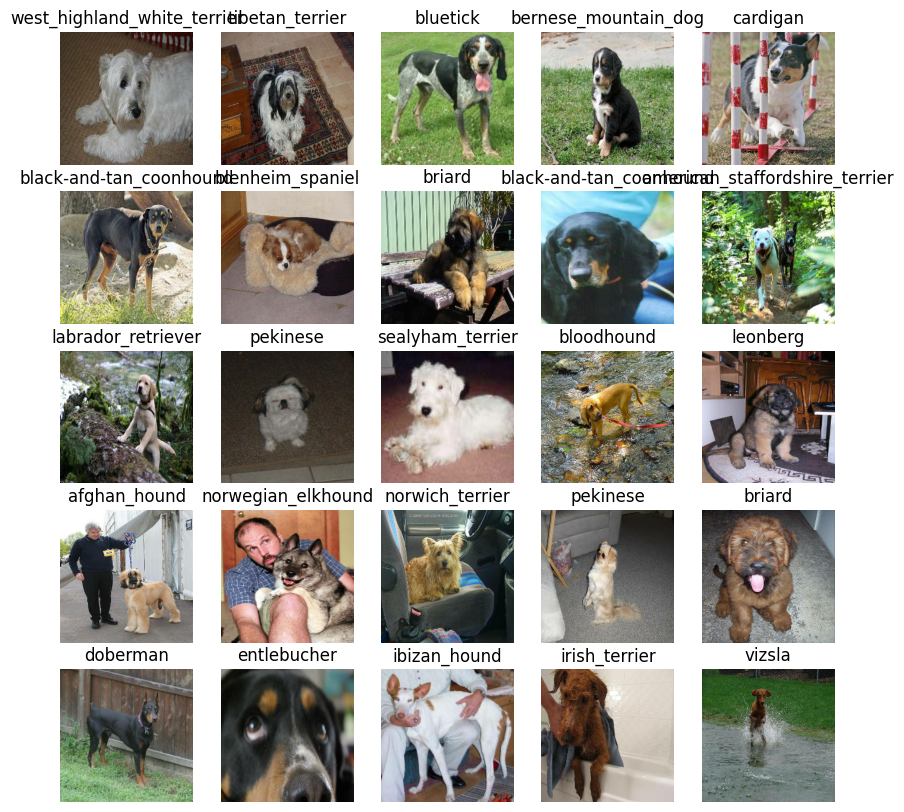

In [37]:
# Now let's visualize the data in a training batch
train_images, train_lables = next(train_data.as_numpy_iterator())
len(train_images), len(train_lables)
show_25_images(train_images, train_lables)

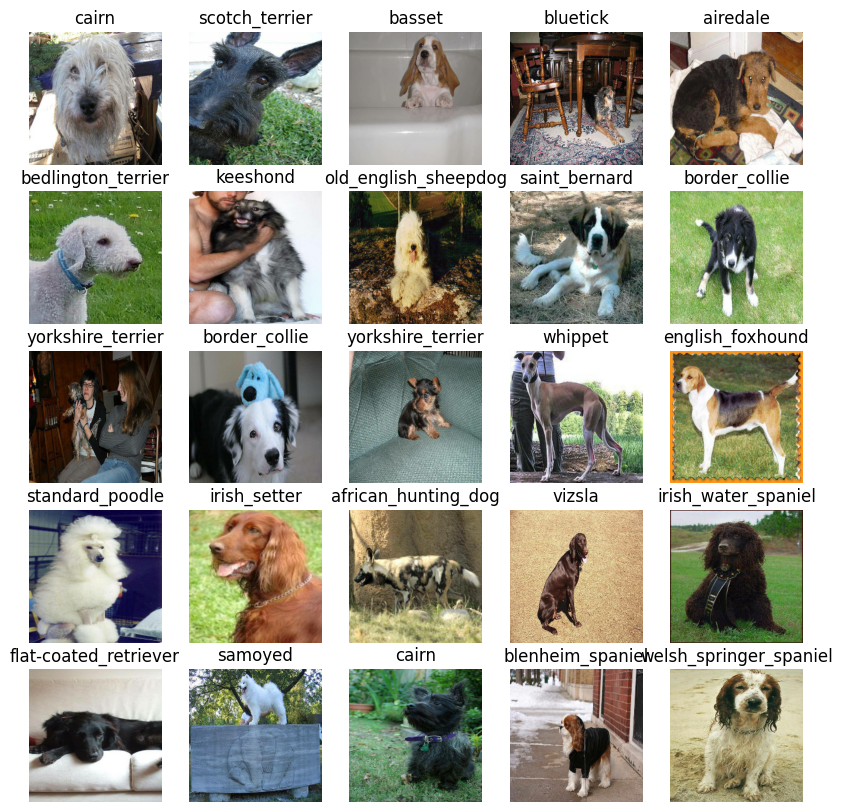

In [38]:
# Now let's visualize the data in a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Buliding a model
Before we build a model, there are a few concepts we have to understand:
* The input shape (the shape of our input data, in this case, the shape of our images).
* The output shape (the shape of our prediction labels, in this case, the shape of our one-hot encoded labels).
* The URL of the model we want to use (in this case, EfficientNetB0 from TensorFlow Hub).

In [39]:
# Setup input shape to the model
INPUT_SHAPE =  [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

#MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

Now we've got our input, output and model ready to go, let's put them together into a Keras deep learning model.

Knowing this, we can use the Keras Functional API to create our model.
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential function(do this first then this then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

In [40]:
# TF_USE_LEGACY_KERAS=1

# # Create a function which builds a Keras model
# def create_model(input_shape=INPUT_SHAPE, ouput_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
#     print("Building model with:", MODEL_URL)

#     # Setup the model layers
#     model = tf.keras.Sequential([
#         hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
#         tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
#                               activation='softmax')(x) # Layer 2 (output layer)
#     ])

#     # Compile the model
#     model.compile(
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         optimizer=tf.keras.optimizers.Adam(),
#         metrics=['accuracy']
#     )

#     # Build the model
#     model.biuld(input_shape=INPUT_SHAPE[:1])

#     return model

In [41]:
from tensorflow.keras.models import Sequential

def create_model_2(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building model...")
    # Setup the base of the model
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE[1:])
    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Sequential([
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu')
    ])(x)
    outputs = Dense(OUTPUT_SHAPE, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model




In [42]:

model = create_model_2()
model.summary()

Building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,093,560 (11.80 MB)

 Trainable params: 835,576 (3.19 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
outputs = np.ones(shape=(1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [44]:
# Loas the TensorBoard notebook extension
%load_ext tensorboard

In [45]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)


#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [46]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.

In [47]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Boom! We've got a GPU running and `NUM_EPOCHS` setup. Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [48]:
def train_model():
    """
    Trains a given model and returns the trained version. 
    """
    # Create a model
    model = create_model_2()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])

    return model

In [49]:
# Fit the model to the data
model = train_model()

Building model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 870ms/step - accuracy: 0.0189 - loss: 4.8560 - val_accuracy: 0.0450 - val_loss: 4.6101
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 804ms/step - accuracy: 0.1234 - loss: 4.2473 - val_accuracy: 0.1750 - val_loss: 3.9246
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - accuracy: 0.3228 - loss: 3.0000 - val_accuracy: 0.3300 - val_loss: 3.0395
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 810ms/step - accuracy: 0.5971 - loss: 1.7259 - val_accuracy: 0.4100 - val_loss: 2.2847
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - accuracy: 0.7247 - loss: 1.0882 - val_accuracy: 0.5150 - val_loss: 2.0290
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 848ms/step - accuracy: 0.7904 - loss: 0.7293 - val_accuracy: 0.5050 - val_loss: 1.8878
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - accuracy: 0.8467 - loss: 0.4979 - val_accuracy: 0.5300 - val_loss: 2.0207
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 820ms/step - accuracy: 0.8906

#### Checking the TensorBoard logs
Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [71]:
%tensorboard --logdir logs --port 80

### Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [51]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 867ms/step


array([[1.23150503e-05, 8.05755008e-06, 7.42706675e-07, ...,
        2.55658676e-07, 1.01020469e-05, 1.56766560e-04],
       [8.08882646e-07, 5.96673963e-05, 2.32504824e-08, ...,
        1.39836320e-05, 8.40805296e-06, 5.43938449e-06],
       [4.76346296e-09, 1.61700918e-05, 5.94368288e-08, ...,
        3.25047083e-08, 3.29684902e-09, 5.10472603e-07],
       ...,
       [3.66941749e-05, 1.09851698e-07, 7.01211755e-09, ...,
        1.37964594e-06, 8.22090840e-08, 9.99910299e-07],
       [1.30727021e-05, 1.13056075e-07, 5.65735547e-07, ...,
        1.00599173e-08, 6.55041731e-07, 2.96287326e-05],
       [1.48759921e-06, 6.08153128e-09, 5.06974118e-07, ...,
        2.40438993e-07, 3.85798529e-07, 4.11219702e-07]], dtype=float32)

In [52]:
predictions.shape

(200, 120)

In [53]:
len(y_val), len(predictions), len(unique_breeds)

(200, 200, 120)

In [54]:
predictions[0]

array([1.2315050e-05, 8.0575501e-06, 7.4270667e-07, 1.9062021e-04,
       3.5863115e-06, 8.9476653e-06, 4.8566607e-04, 1.7525645e-07,
       2.2008115e-05, 1.0999923e-08, 6.8811451e-06, 5.9898907e-06,
       2.4230084e-07, 6.2150793e-06, 6.9806703e-07, 7.8490388e-08,
       2.6240474e-07, 8.5527299e-04, 4.2988052e-07, 8.3934815e-08,
       3.8756806e-07, 1.1120389e-06, 1.1497140e-05, 4.4881919e-04,
       3.6446269e-07, 4.7083702e-08, 3.4220377e-04, 2.8595593e-08,
       1.7054882e-06, 2.6058467e-06, 1.7012141e-08, 2.1933358e-04,
       1.0673944e-06, 3.8017170e-06, 1.2705924e-05, 1.8955551e-02,
       1.1966928e-07, 1.2853695e-07, 4.2071315e-07, 6.0208026e-07,
       2.3287439e-06, 3.2217446e-07, 2.6775714e-07, 3.1062726e-08,
       7.2092256e-08, 9.4404703e-07, 5.4895515e-09, 4.7142898e-09,
       3.4911893e-05, 1.1575915e-05, 4.4804910e-10, 2.5582688e-06,
       1.6376644e-05, 5.8157692e-08, 2.0252700e-07, 4.0092446e-10,
       1.3382617e-11, 2.0707501e-04, 2.9952108e-07, 1.0288706e

In [55]:
len(predictions[0])

120

In [56]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}") # Should be close to 1
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")


[2.35167952e-09 1.00586661e-07 1.34252531e-09 2.94261808e-05
 1.10047722e-05 2.47092729e-08 5.25769046e-08 2.15832726e-04
 1.60540891e-04 8.36619874e-05 1.26839652e-07 3.89997457e-09
 4.84129792e-10 5.09145553e-04 3.13997452e-06 8.45021787e-05
 1.86275939e-10 2.17636860e-08 5.75437327e-04 4.87014574e-07
 9.90757736e-12 1.25039080e-02 6.02763339e-06 4.22093990e-06
 9.17015364e-04 1.53542182e-03 1.00643161e-13 1.58897342e-06
 8.60674643e-09 1.67086995e-07 6.51533341e-11 3.60640726e-08
 4.63930299e-08 2.18561482e-07 9.40066025e-10 1.68043087e-07
 1.43739794e-11 1.59525740e-07 7.05475012e-10 5.03219843e-01
 7.34998764e-08 1.08895408e-08 4.97454630e-06 6.89840185e-10
 6.81758763e-07 3.35055233e-07 6.50789353e-11 1.04483172e-06
 5.34960565e-14 4.99134201e-09 8.69388155e-12 4.27089435e-06
 4.77390127e-10 5.73681200e-06 2.79535986e-12 2.48948454e-05
 1.24741073e-09 4.17709529e-08 3.94479900e-11 2.52569684e-11
 3.59721753e-07 2.16490026e-08 6.55155860e-11 2.42321874e-12
 7.57247477e-12 6.993753

In [57]:
unique_breeds[39]

'english_foxhound'

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

**Note:** Prediction probabilities are also known as confidence levels.

In [58]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'chihuahua'

In [59]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [60]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """
    images = []
    labels = []

    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[:2], val_labels[:2]

([array([[[0.29599646, 0.43284872, 0.3056691 ],
          [0.26635826, 0.32996926, 0.22846507],
          [0.31428418, 0.27701408, 0.22934894],
          ...,
          [0.77614343, 0.82320225, 0.8101595 ],
          [0.81291157, 0.8285351 , 0.8406944 ],
          [0.8209297 , 0.8263737 , 0.8423668 ]],
  
         [[0.2344871 , 0.31603682, 0.19543913],
          [0.3414841 , 0.36560842, 0.27241898],
          [0.45016077, 0.40117094, 0.33964607],
          ...,
          [0.7663987 , 0.8134138 , 0.81350833],
          [0.7304248 , 0.75012016, 0.76590735],
          [0.74518913, 0.76002574, 0.7830809 ]],
  
         [[0.30157745, 0.3082587 , 0.21018331],
          [0.2905954 , 0.27066195, 0.18401104],
          [0.4138316 , 0.36170745, 0.2964005 ],
          ...,
          [0.79871625, 0.8418535 , 0.8606443 ],
          [0.7957738 , 0.82859945, 0.8605655 ],
          [0.75181633, 0.77904975, 0.8155256 ]],
  
         ...,
  
         [[0.9746779 , 0.9878955 , 0.9342279 ],
          [0.9

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [61]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n.
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)


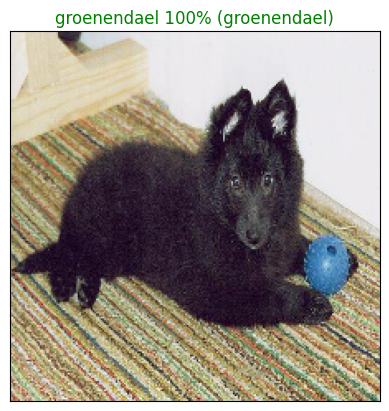

In [62]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
            n=77
          )

Nice! Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

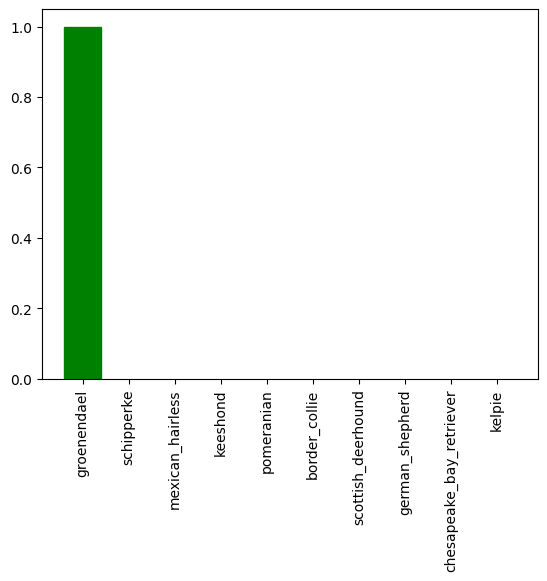

In [63]:
# Create a function to view the top 10 prediction confidences
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """

    preds_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(preds_prob)

    # Find the top 10 prediction confidence indexes
    top_pred_indexes = preds_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = preds_prob[top_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="grey")

    plt.xticks(np.arange(len(top_10_pred_labels)),
                labels=top_10_pred_labels,
                rotation="vertical")
    
    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=77)


Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

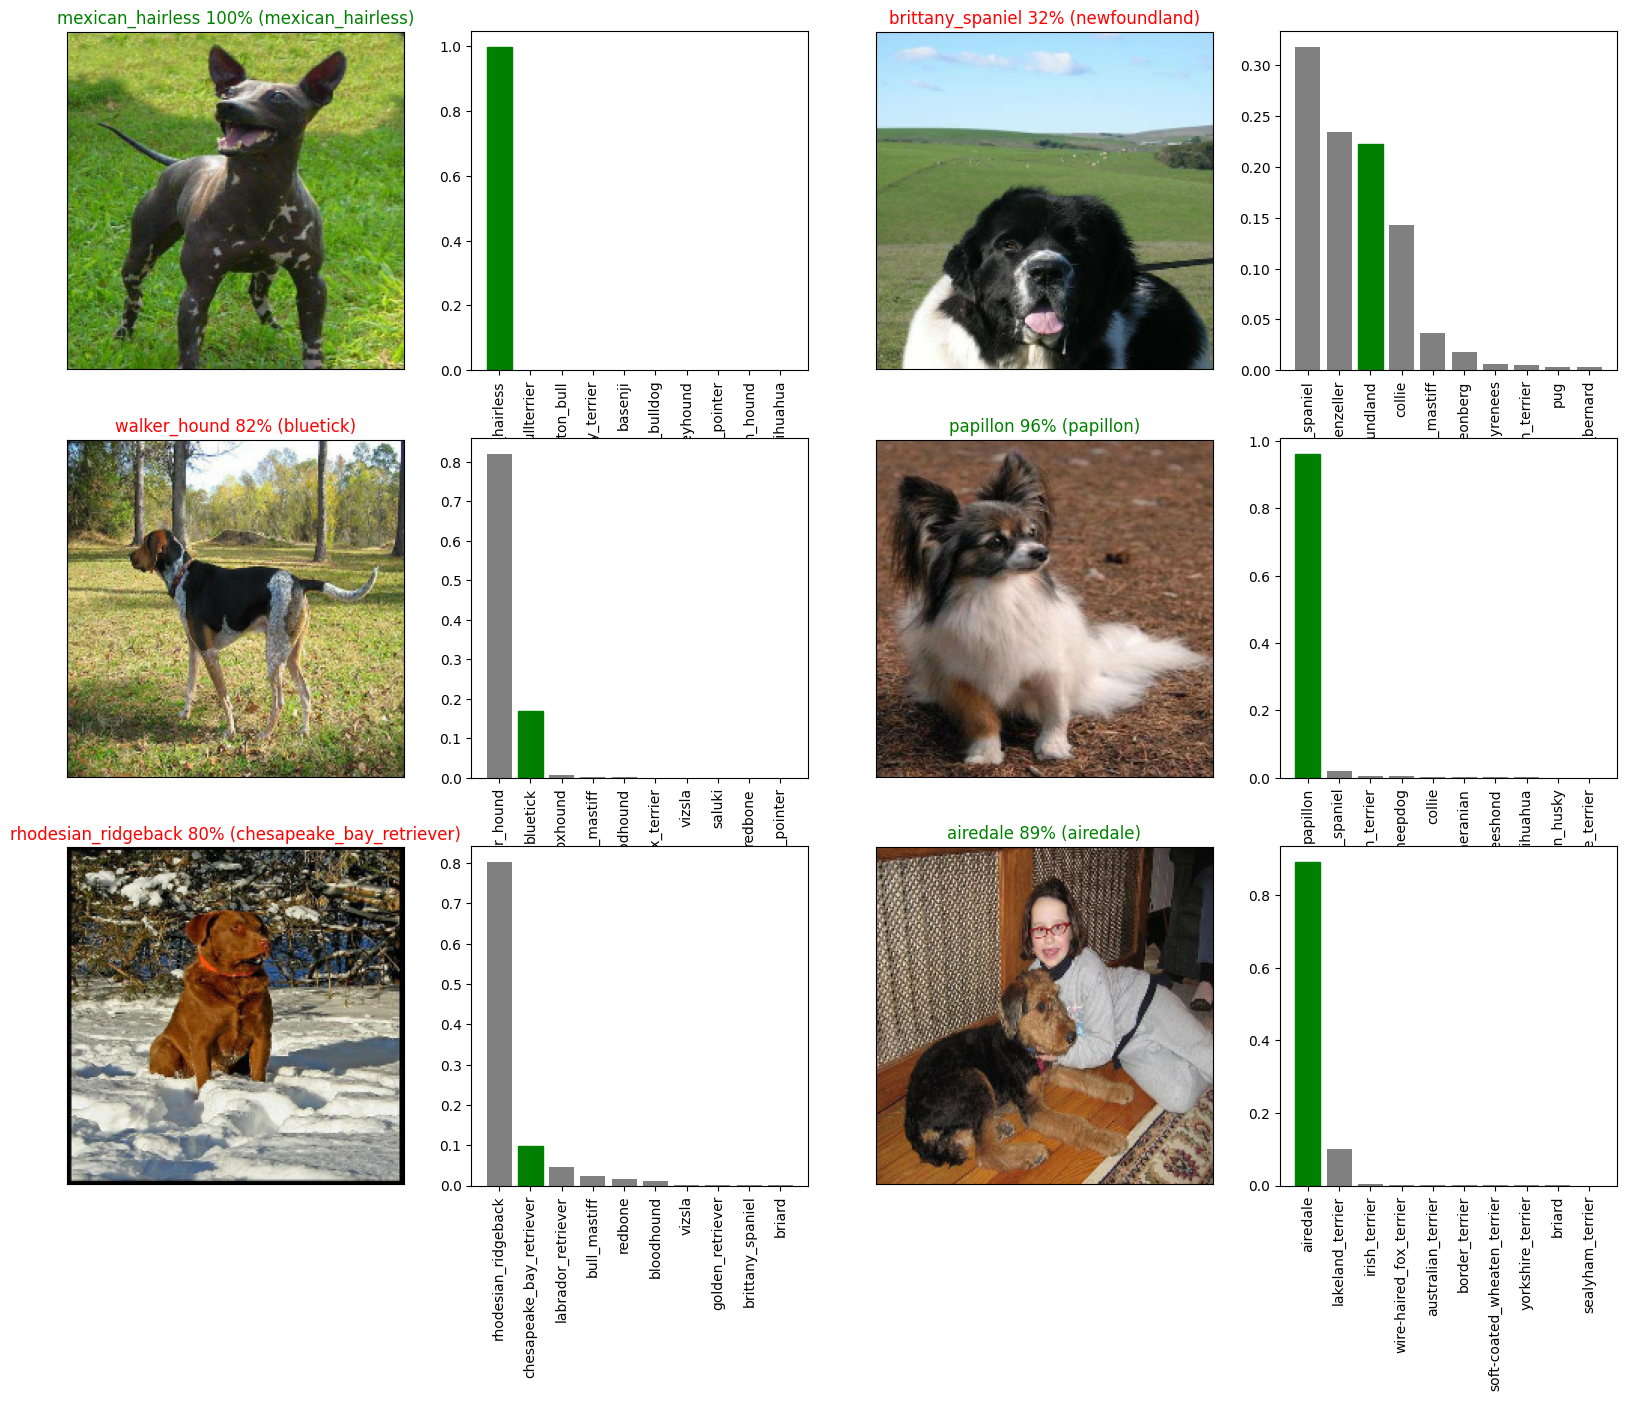

In [64]:
# Let's check out a few predictions and their different values
i_multiplier = 70
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
    
plt.show()

## Saving and reloading a model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the [`save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) method to save it as a h5 file to a specified directory.

In [65]:
# Create a funtcion to save a model

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    model_path = modeldir + "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path


In [66]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [67]:
# Save the model
save_model(model, suffix="1000-images-100-epochs-mobilenetv2")

Saving model to: model\20240927-183933-1000-images-100-epochs-mobilenetv2.h5...


'model\\20240927-183933-1000-images-100-epochs-mobilenetv2.h5'

In [68]:
# Load the model
loaded_model = load_model("model/20240925-003858-1000-images-100-epochs-mobilenetv2.h5")

Loading saved model from: model/20240925-003858-1000-images-100-epochs-mobilenetv2.h5


In [69]:
# Evaluate the loaded model
model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.5708 - loss: 1.8705


[1.8560806512832642, 0.5799999833106995]

In [70]:
# Evaluate the loaded model
loaded_model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.5499 - loss: 1.8082


[1.8076145648956299, 0.5550000071525574]

## Training a model (on the full data)

Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to `X` and all of the training labels to `y`. Let's check them out.

In [72]:
len(x_train)

800

In [73]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [74]:
# Create a data batch with the full data set
full_data = create_data_batches(x, y)

Creating training data batches...


In [75]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [76]:
# Create a model for full model
full_model = create_model_2()

Building model...


In [77]:
# Create full model callback
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

**Note:** Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our `full_model_early_stopping` callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [78]:
# Fit the full model to the full data
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 223s 682ms/step - accuracy: 0.2555 - loss: 3.3457
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 204s 637ms/step - accuracy: 0.6464 - loss: 1.1706
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 205s 639ms/step - accuracy: 0.7059 - loss: 0.9373
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 213s 665ms/step - accuracy: 0.7412 - loss: 0.8207
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 223s 698ms/step - accuracy: 0.7584 - loss: 0.7421
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 214s 668ms/step - accuracy: 0.7898 - loss: 0.6530
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 214s 670ms/step - accuracy: 0.8024 - loss: 0.6032
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 210s 656ms/step - accuracy: 0.8222 - loss: 0.5407
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 210s 657ms/step - accuracy: 0.8377 - loss: 0.4890
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 212s 662ms/step - accuracy: 0.8361 - loss: 0.4935
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 202s 631ms/step - accuracy: 0.8620 - loss: 0.41

In [79]:
save_model(full_model, suffix="10000-images-100-epochs-mobilenetv2-full_model")

Saving model to: model\20240927-212349-10000-images-100-epochs-mobilenetv2-full_model.h5...


'model\\20240927-212349-10000-images-100-epochs-mobilenetv2-full_model.h5'

In [82]:
load_full_saved_model = load_model('model/20240927-212349-10000-images-100-epochs-mobilenetv2-full_model.h5')

Loading saved model from: model/20240927-212349-10000-images-100-epochs-mobilenetv2-full_model.h5


In [84]:
load_full_saved_model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 604ms/step - accuracy: 0.9865 - loss: 0.0986


[0.06403150409460068, 0.9900000095367432]

In [85]:
len(x)

10222

### Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [86]:
test_path = "data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['data/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [87]:
len(test_filenames)

10357

In [89]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [90]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [91]:
# Make predictions on test data batch using the loaded full model
test_preds = load_full_saved_model.predict(test_data, verbose=1)

324/324 ━━━━━━━━━━━━━━━━━━━━ 245s 753ms/step


In [92]:
test_preds[:10]

array([[1.1759013e-13, 9.1760960e-10, 2.1748573e-15, ..., 1.5828605e-14,
        4.1388784e-10, 1.0241811e-09],
       [4.6323552e-13, 5.3643427e-11, 1.5461900e-14, ..., 1.2873685e-15,
        6.1160320e-11, 6.0806632e-14],
       [5.0318386e-06, 3.4342145e-03, 3.2886450e-07, ..., 1.2188834e-05,
        1.3778050e-06, 3.4924130e-06],
       ...,
       [1.9692889e-12, 2.4582252e-09, 2.2348126e-14, ..., 9.3992222e-15,
        4.4917711e-10, 6.5336178e-14],
       [2.0456263e-09, 6.2007075e-07, 4.2102100e-11, ..., 1.2844351e-08,
        2.2820731e-10, 3.3735170e-09],
       [2.1067682e-11, 1.1004988e-08, 2.9377822e-12, ..., 1.6404757e-13,
        2.8770272e-13, 7.2885246e-11]], dtype=float32)

In [93]:
test_preds.shape

(10357, 120)

### Preparing test dataset predictions for Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:
*   Create a pandas DataFrame with an ID column as well as a column for each dog breed.
*   Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.


In [95]:
# Create a pandas DataFrame with empty colums
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [103]:
# Append test iamge ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [104]:
preds_df.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           NaN          NaN   
1  00102ee9d8eb90812350685311fe5890           NaN          NaN   
2  0012a730dfa437f5f3613fb75efcd4ce           NaN          NaN   
3  001510bc8570bbeee98c8d80c8a95ec1           NaN          NaN   
4  001a5f3114548acdefa3d4da05474c2e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [105]:
# Add the predictions probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_preds
preds_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   1.175901e-13  9.176096e-10   
1  00102ee9d8eb90812350685311fe5890   4.632355e-13  5.364343e-11   
2  0012a730dfa437f5f3613fb75efcd4ce   5.031839e-06  3.434215e-03   
3  001510bc8570bbeee98c8d80c8a95ec1   5.963982e-05  1.983166e-05   
4  001a5f3114548acdefa3d4da05474c2e   4.567356e-03  7.501292e-04   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         2.174857e-15  2.224014e-14                    2.440860e-14   
1         1.546190e-14  6.076049e-14                    1.171396e-06   
2         3.288645e-07  6.155795e-06                    6.907674e-08   
3         3.616940e-07  5.015714e-07                    4.933217e-05   
4         1.120647e-05  7.603277e-08                    1.915198e-06   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  2.982972e-09        3.537325e-12  2.527698e-13  3.858900e-12  ...   
1  2.350871e-12        6.790009e-17  1.934827e-14  1.095713e-17  ...   
2  1.745024e-06        2.959273e-06  5.110858e-08  4.552870e-04  ...   
3  9.823373e-05        1.385977e-06  1.297312e-06  7.935993e-07  ...   
4  7.629185e-06        2.590468e-05  9.723368e-06  1.768761e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.682275e-13  1.799399e-11  3.790645e-14  3.031495e-14  1.424350e-14   
1  4.483707e-12  4.590096e-16  9.230908e-19  6.168448e-18  3.049235e-13   
2  5.470511e-06  1.467758e-07  8.418461e-06  9.989080e-06  1.207985e-05   
3  5.730940e-07  6.022992e-07  4.693985e-05  3.854684e-07  3.524403e-04   
4  3.114644e-06  7.784909e-07  1.408011e-06  9.931511e-09  5.639362e-07   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            3.404352e-11                 1.076082e-11  1.582860e-14   
1            6.743659e-14                 2.309274e-08  1.287369e-15   
2            9.686906e-04                 1.833622e-08  1.218883e-05   
3            1.298656e-06                 2.645692e-06  5.155005e-05   
4            4.495116e-06                 5.238719e-06  4.835454e-04   

   wire-haired_fox_terrier  yorkshire_terrier  
0             4.138878e-10       1.024181e-09  
1             6.116032e-11       6.080663e-14  
2             1.377805e-06       3.492413e-06  
3             9.903534e-07       2.205781e-05  
4             1.108206e-04       1.187922e-05  

[5 rows x 121 columns]

In [107]:
preds_df.to_csv("model/full_model_predictions.csv", index=False)